In [4]:
import sys
sys.path.append('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project')
import re
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from Scripts.add_features import medication_score, add_tweet_info


### Importação dos datasets

- `df_train`: dataset de treino
- `df_test`: dataset de teste

In [6]:
df_train = pd.read_csv('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project\\Data\\task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project\\Data\\task1_testing.csv', delimiter = '\t')


In [7]:
print(df_train['class'].value_counts())
print()
print(df_test['label'].value_counts())


class
0    55273
1      146
Name: count, dtype: int64

label
0    13817
1       36
Name: count, dtype: int64


#### Feature engineering

In [8]:
add_tweet_info(df_train)
add_tweet_info(df_test)

### Pré processamento do texto

Processamento básico:

- minúsculas
- remover urls
- remover usernames
- remover pontuaçao repetida (exemplo: 'YES!!!' -> 'YES!')
- separar pontuação
- remover símbolos •‘’“”
- remover &amp &lt &gt
- remover #

In [9]:
from Scripts.process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

#### Tokenization + Lemmatization

In [10]:
from Scripts.process import lemma_tokenizer

lemma_tokenizer(df_train, 'tweet')
lemma_tokenizer(df_test, 'tweet')

### Remoção de stopwords

In [11]:
from Scripts.process import remove_stopwords

remove_stopwords(df_train, 'tweet')
remove_stopwords(df_test, 'tweet')

#### Wordcloud

Training dataset


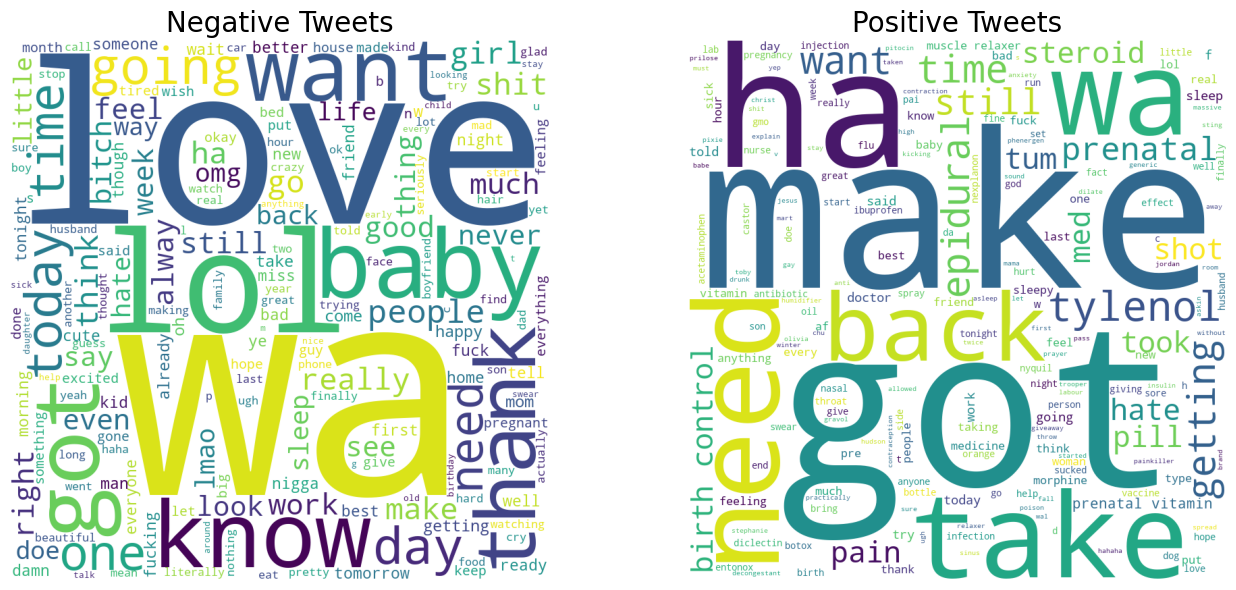

In [12]:
from Scripts.dataset_analysis import wordcloud

wordcloud(df_train, 'tweet', 'class', 'Training dataset', 'white')


Testing dataset


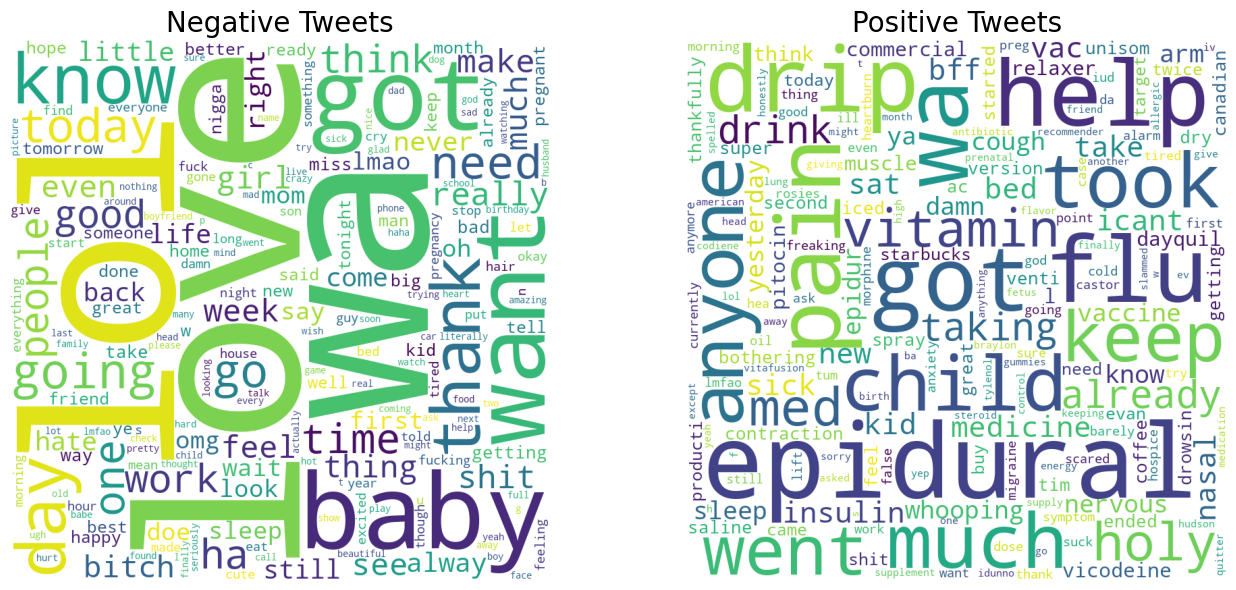

In [13]:
from Scripts.dataset_analysis import wordcloud

wordcloud(df_test, 'tweet', 'label', 'Testing dataset', 'white')


In [14]:
#criaçao de X_train, y_train, X_test, y_test

X_train = df_train['tweet']
y_train = df_train['class']

X_test = df_test['tweet']
y_test = df_test['label']

In [15]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (55419,)
X_test shape:  (13853,)
y_train shape:  (55419,)
y_test shape:  (13853,)


In [16]:
def dummy_tokenizer(text):
    return text

In [17]:
tfidf = TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)  

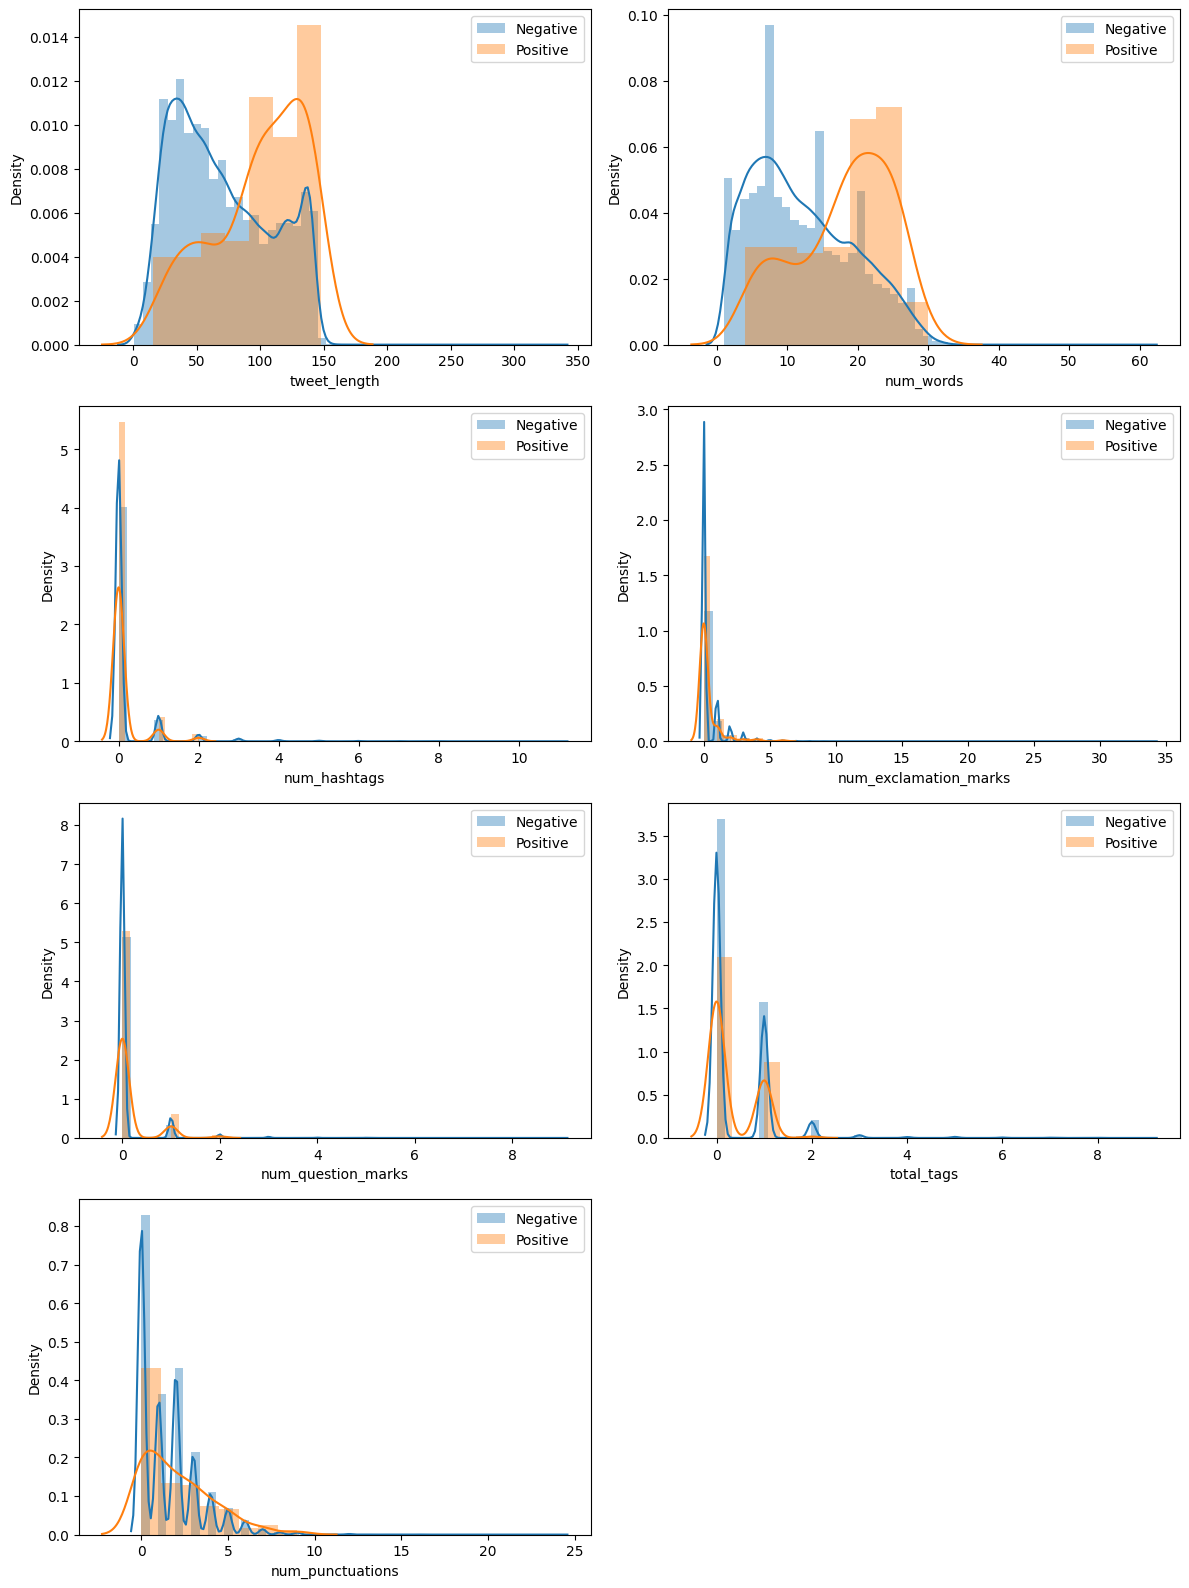

In [19]:
import seaborn as sns


# Visualizing relationship of newly created features
plt.figure(figsize=(12, 16))
features = ['tweet_length', 'num_words', 'num_hashtags', 'num_exclamation_marks', 'num_question_marks', 
            'total_tags', 'num_punctuations']
for i in range(len(features)):
    plt.subplot(4, 2, i+1)
    sns.distplot(df_train[df_train['class']==0][features[i]], label = 'Negative')
    sns.distplot(df_train[df_train['class']==1][features[i]], label = 'Positive')
    plt.legend()
plt.tight_layout()
plt.show()

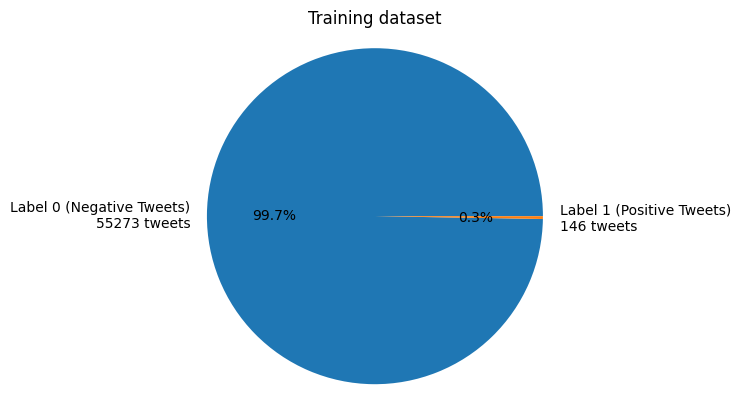

In [20]:
# Class Imbalance Check
plt.pie(df_train['class'].value_counts(), 
        labels=[f'Label 0 (Negative Tweets)\n{len(df_train[df_train["class"]==0])} tweets', f'Label 1 (Positive Tweets)\n{len(df_train[df_train["class"]==1])} tweets'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.title('Training dataset')
plt.show()

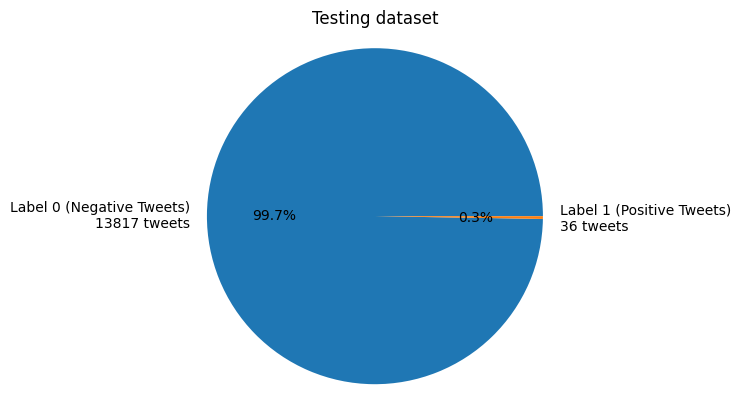

In [21]:
# Class Imbalance Check
plt.pie(df_test['label'].value_counts(), 
        labels=[f'Label 0 (Negative Tweets)\n{len(df_test[df_test["label"]==0])} tweets', f'Label 1 (Positive Tweets)\n{len(df_test[df_test["label"]==1])} tweets'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.title('Testing dataset')
plt.show()

### Smote

In [22]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)


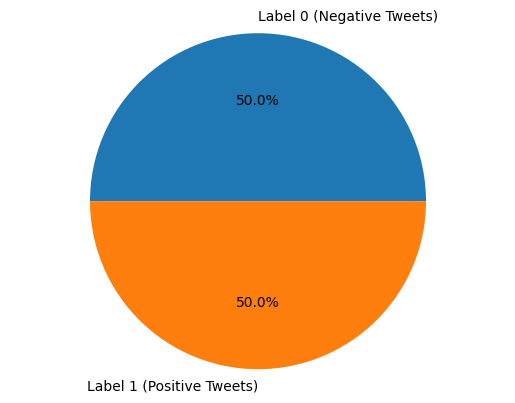

In [23]:
# Class Imbalance Check
plt.pie(pd.value_counts(y_train_resampled), 
        labels=['Label 0 (Negative Tweets)', 'Label 1 (Positive Tweets)'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [25]:
df_train = pd.read_csv('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project\\Data\\task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('C:\\Users\\Paulo Seixal\\OneDrive - Universidade do Minho\\Documentos\\PYTHONPATH\GitHub\\tweet_mining_project\\Data\\task1_testing.csv', delimiter = '\t')

from Scripts.process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

### Unigrams

#### Training dataset

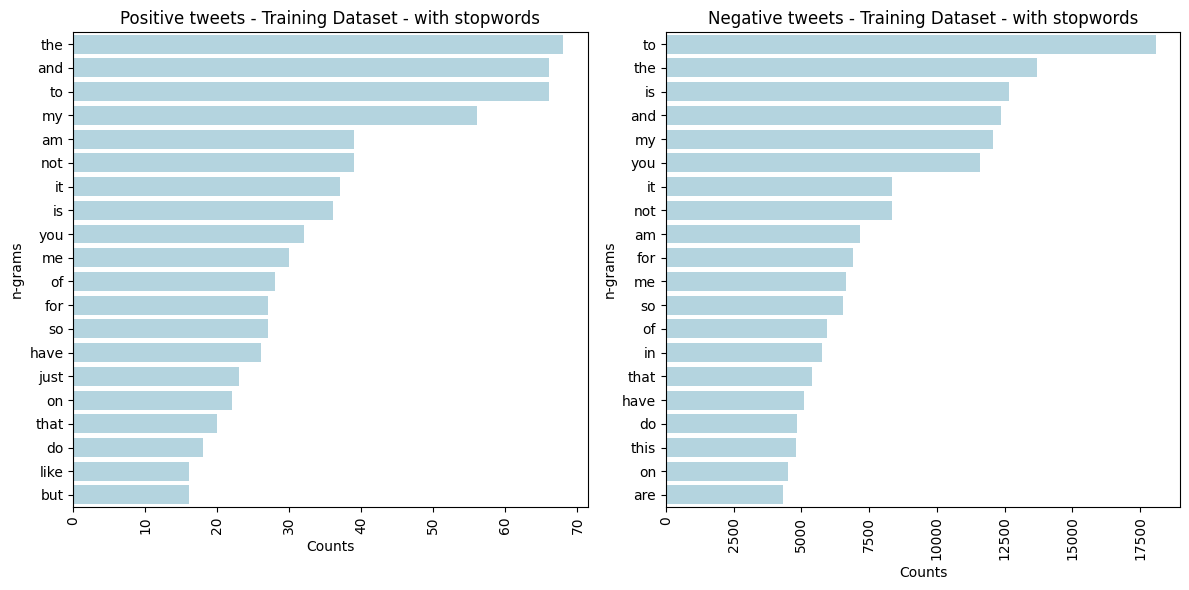

In [26]:
from Scripts.dataset_analysis import n_gram_analysis

n_gram_analysis(df_train, 'Training Dataset', 'class', stopwords_removal=False, n_grams=1)

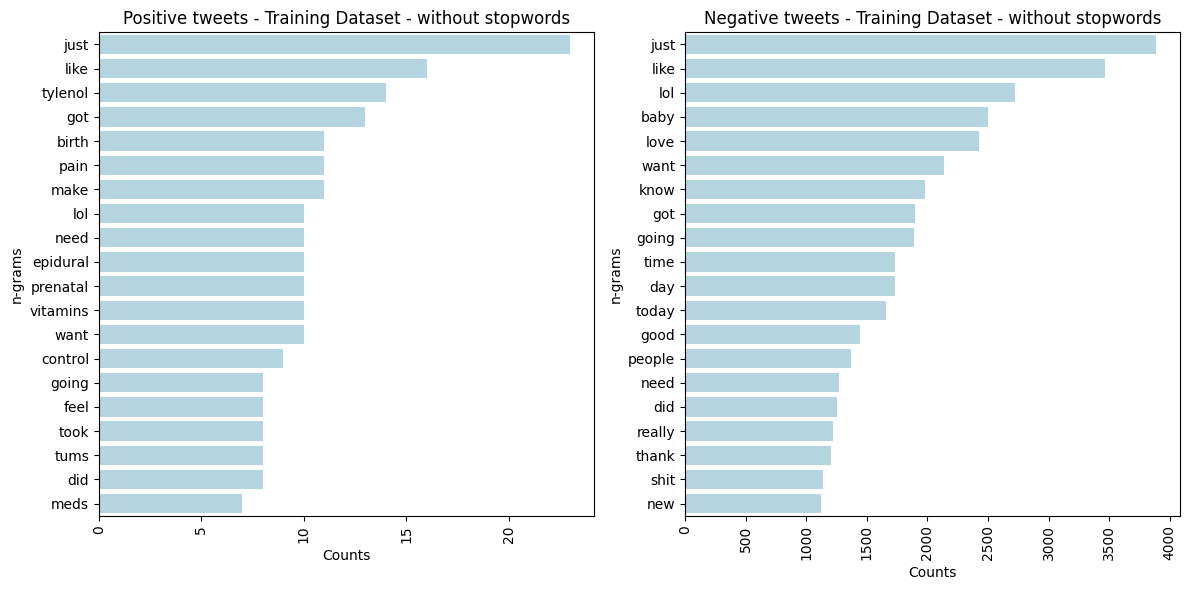

In [27]:
n_gram_analysis(df_train, 'Training Dataset', 'class', stopwords_removal=True, n_grams=1)

#### Testing dataset

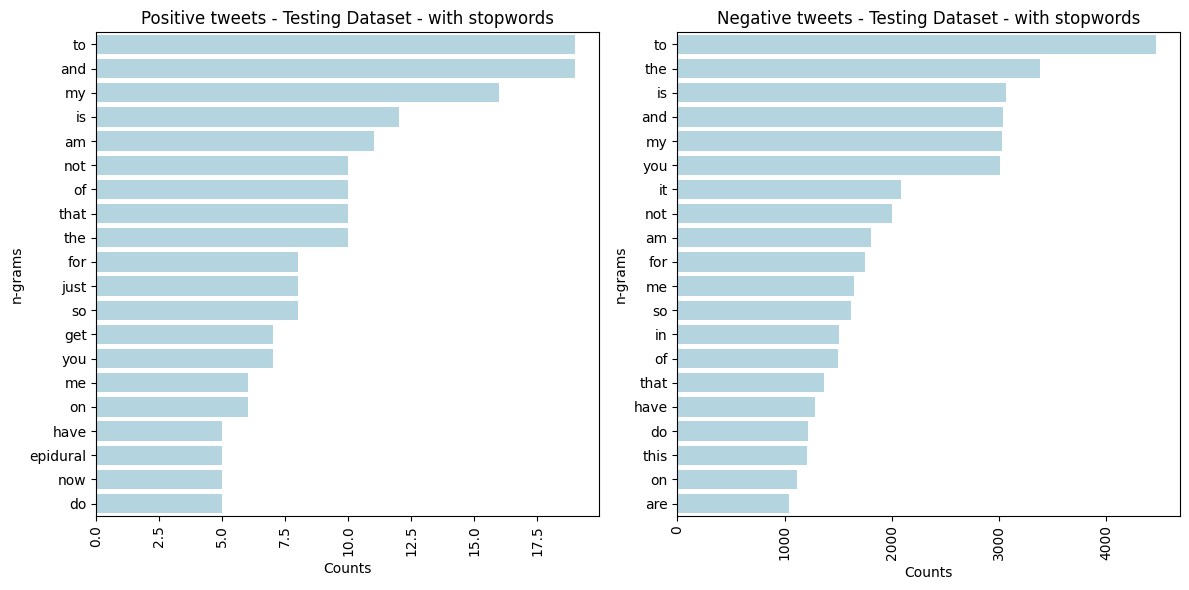

In [28]:
n_gram_analysis(df_test, 'Testing Dataset', 'label', stopwords_removal=False, n_grams=1)

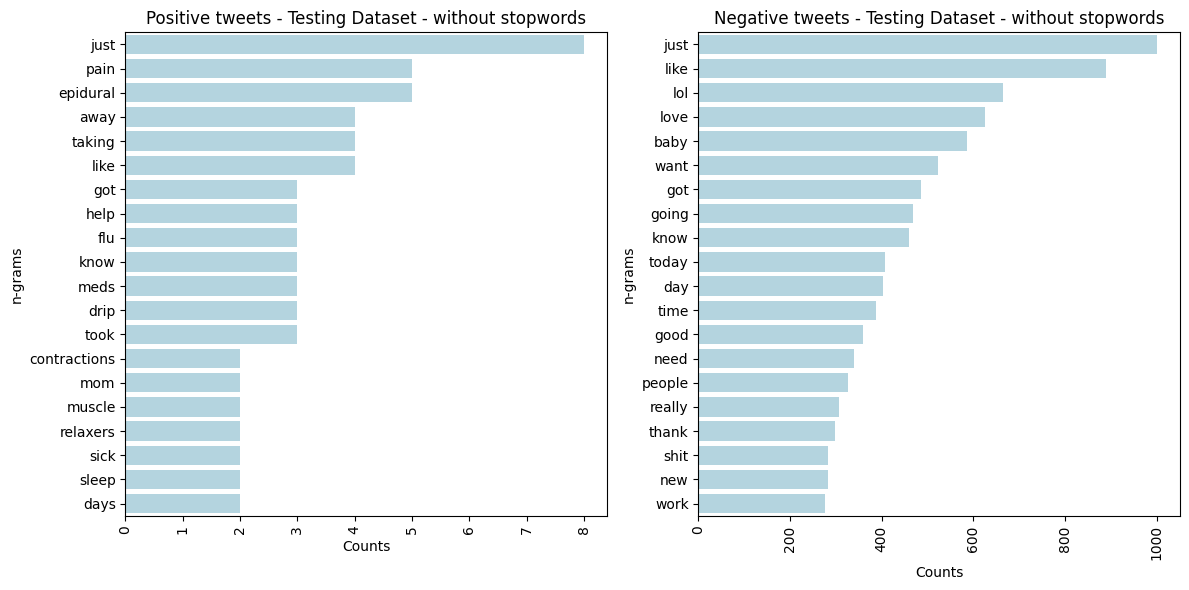

In [29]:
n_gram_analysis(df_test, 'Testing Dataset', 'label', stopwords_removal=True, n_grams=1)

### Bigrams

#### Training dataset

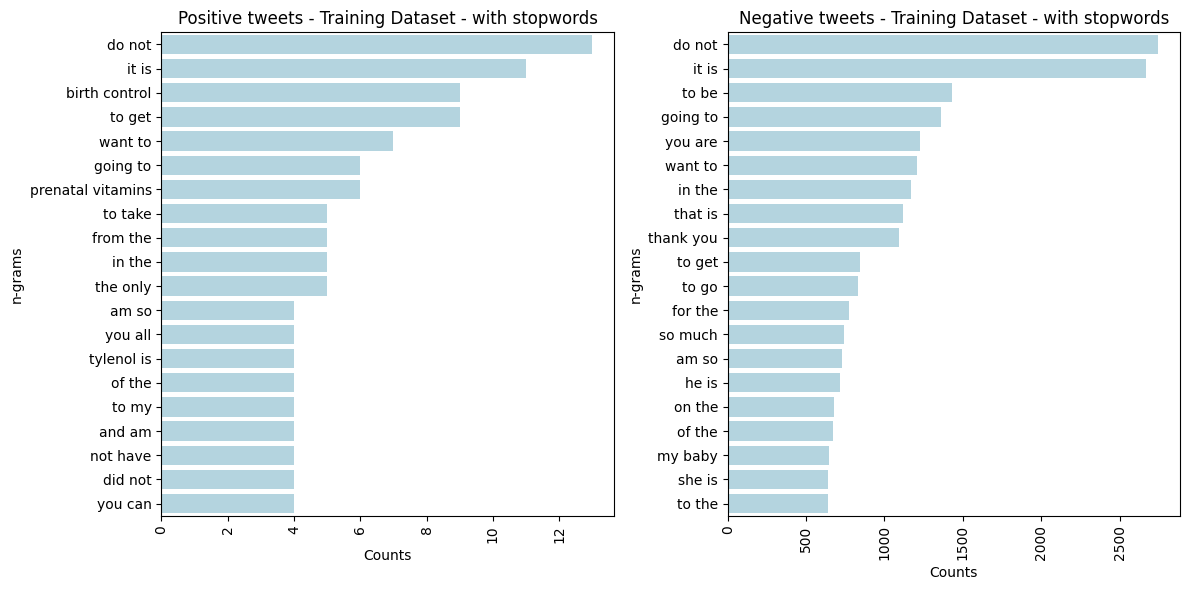

In [30]:
n_gram_analysis(df_train, 'Training Dataset', 'class', stopwords_removal=False, n_grams=2)

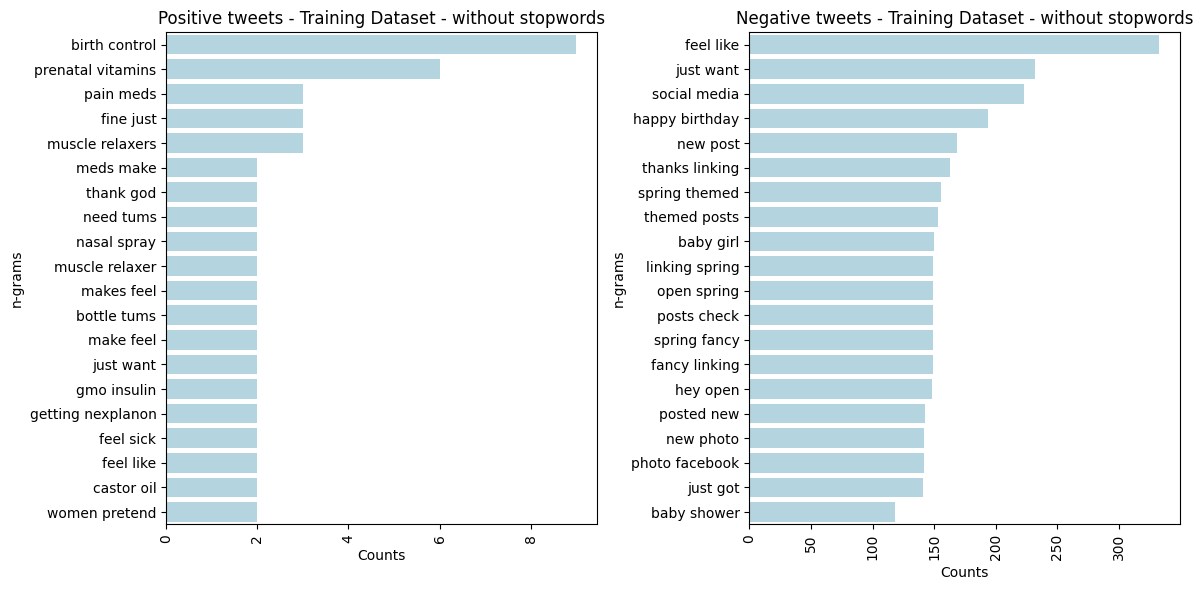

In [31]:
n_gram_analysis(df_train, 'Training Dataset', 'class', stopwords_removal=True, n_grams=2)

#### Testing dataset

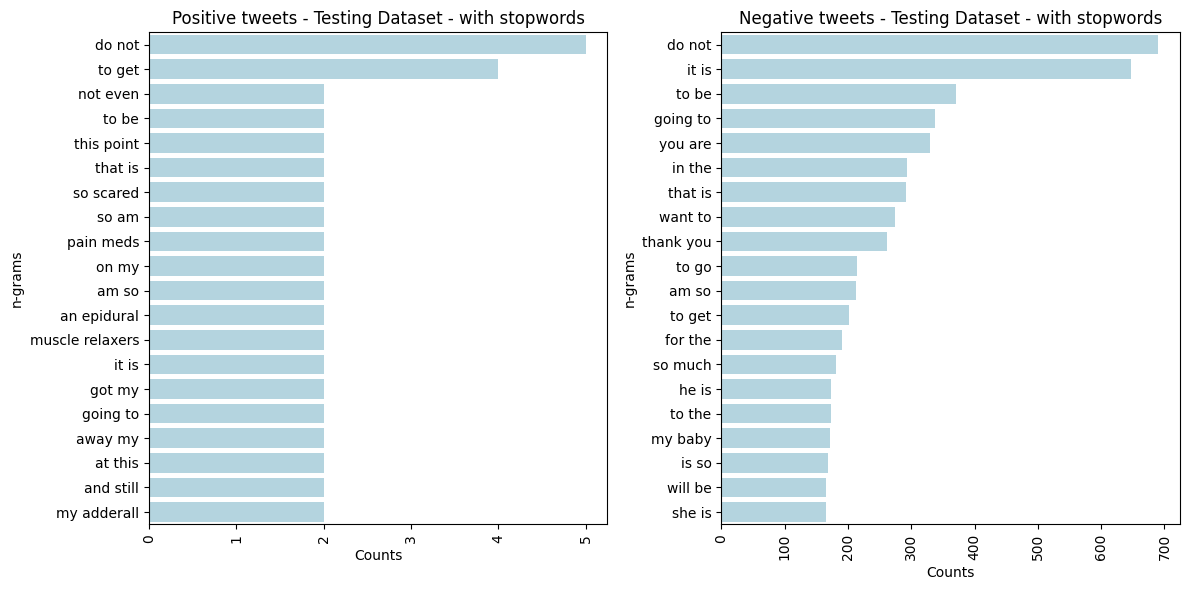

In [32]:
n_gram_analysis(df_test, 'Testing Dataset', 'label', stopwords_removal=False, n_grams=2)

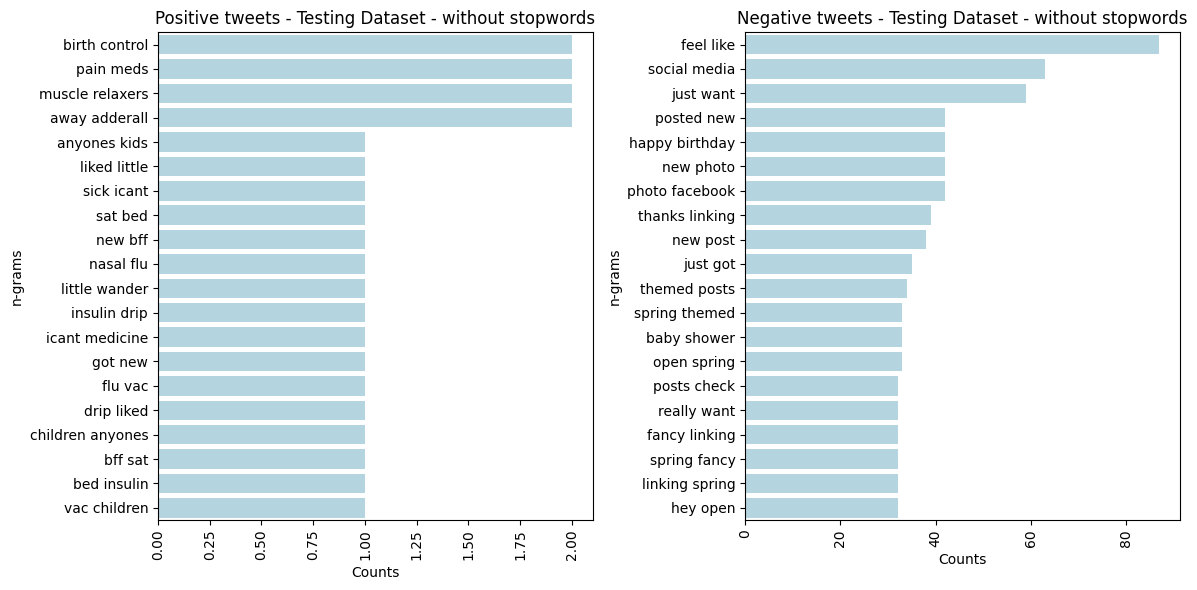

In [33]:
n_gram_analysis(df_test, 'Testing Dataset', 'label', stopwords_removal=True, n_grams=2)